In [2]:
from cvxpy import *
import numpy as np
import networkx as nx
import scipy.linalg as sla
import mosek
import matplotlib.pyplot as plt
%precision %.2f
np.set_printoptions(precision=2)

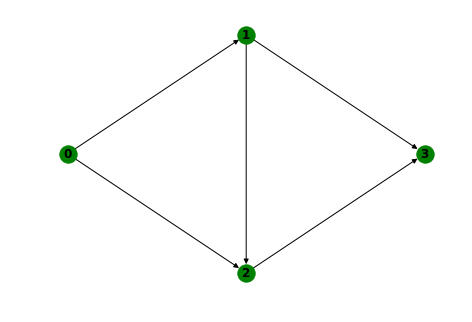

In [3]:
# Graph set up 
edges = [(0,1),(0,2), (1,2), (2,3), (1,3)] ;
edges2 = [(0,1),(0,2), (2,3), (1,3)] ; # removed middle edge
wheat = nx.DiGraph(edges);
wheatRemoved = nx.DiGraph(edges2);
# Degree/Incidence matrix
E = nx.incidence_matrix(wheat, oriented=True).toarray();
E2 = nx.incidence_matrix(wheatRemoved, oriented=True).toarray();
# Number of edges
e = wheat.number_of_edges();
# Number of nodes
v = wheat.number_of_nodes();
#Specify their positions
nodePos = {0: (0,1),
           1: (1,2),
           2: (1,0),
           3: (2,1)}
# Draw graph
nx.draw(wheat,pos=nodePos, node_color='g', edge_color='k', with_labels=True, font_weight='bold')
sourceNode = 0;
sinkNode = 3;
sourceVec = np.zeros((v));
sourceVec[sourceNode] = -1;
sourceVec[sinkNode] = 1;

#-------------latency parameters----------------------#
A = np.diag([1., 0, 0, 1, 0.]) #latency for whole graph
b = np.array([0., 1., 0, 0, 1.]) 

ARemoved = np.diag([1., 0, 1, 0.])#latency after removing an edge
bRemoved = np.array([0., 1., 0, 1.])

In [312]:
# Generate routes matrix
def RouteGen(graph, edgeSet, sourceN, sinkN):
    routes =  list(nx.all_simple_paths(graph, source=sourceN, target=sinkN));
    RouteMat = np.zeros((graph.number_of_edges(), len(routes)));
    for route in range(0,len(routes)):
        curRoute = routes[route];#Route is in nodes
        #Look for the index of corresponding edge
        for edge in range(0,len(curRoute)-1):
            #Unpack edge
            start= curRoute[edge]; end = curRoute[edge+1];
            edgeInd = edgeSet.index((start,end)); #find the edge index in list
            RouteMat[edgeInd,route]= 1;
    return RouteMat;
RouteGen(wheat,edges,sourceNode,sinkNode)

array([[ 1.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  1.],
       [ 0.,  1.,  0.]])

In [313]:
# Set up Latency function, social cost, 
def latency(x, A, b): 
    return A.dot(x) +b;
def P(x, A, b): # Wardrop Potential
    xTrans = x.T.dot(A)
    return 0.5*x.T.dot(A).dot(x) + b.T.dot(x);
def Q(x, A, b):  # Average Potential
    return x.T.dot(A.dot(x)) + b.T.dot(x);

In [306]:
# return a function value at the wardrop equilibrium defined using l(x) = Ax + b
def returnPotValues(massIterations, incre, potFunc,graph, edgeSet, sink, source, A,b):
    #returns an array of potential values at wardrop Equilibrium 
    potVals = np.zeros([2,massIterations]);
    RouteMat = RouteGen(graph, edgeSet, sink,source);
    e,r = RouteMat.shape;
    for massInd in range(0,massIterations):
        # Problem data.
        mass = incre*massInd;
        potVals[0,massInd] = mass;
        # Construct the problem.
        #----------------WARDROP EQUILIBRIUM--------------------
        x = Variable(e); 
        z = Variable(r);
        warPot =  b*x + quad_form(x,A)*0.5;
        warObj = Minimize(warPot);
        warConstraints = [0 <= z, 
                          RouteMat*z == x,
                          sum(z) == mass]
        wardrop = Problem(warObj, warConstraints)
        warRes = wardrop.solve(solver=MOSEK)
        # Return the potential value for desired potential
        potVals[1,massInd] = potFunc(x.value,A,b);
        
    return potVals;


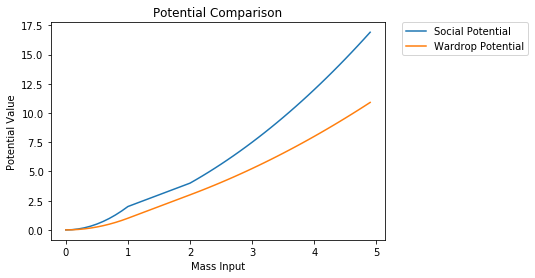

In [307]:
# Compare social potential and wardrop potential of same graph
socialCosts = returnPotValues(50, 0.1, Q, wheat, edges, sourceNode, sinkNode, A,b);  
warCosts = returnPotValues(50, 0.1, P, wheat, edges, sourceNode, sinkNode, A,b);    
plt.figure()
plt.plot(socialCosts[0,:],socialCosts[1,:],label=("Social Potential"));
plt.plot(warCosts[0,:],warCosts[1,:],label=("Wardrop Potential"));
plt.xlabel('Mass Input')
plt.ylabel('Potential Value')
plt.title('Potential Comparison')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

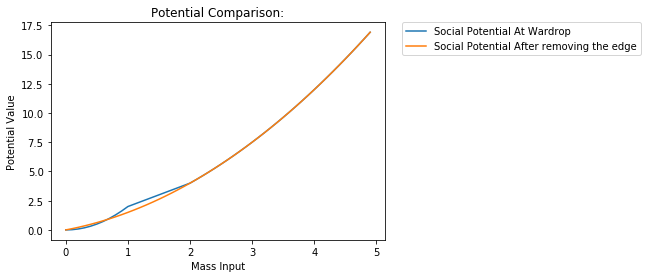

In [308]:
# Compare social potential of graph with/without the edge
socialFull = returnPotValues(50, 0.1, Q, wheat, edges, sourceNode, sinkNode, A,b);  
socialNoEdge = returnPotValues(50, 0.1, Q, wheatRemoved, edges2, sourceNode, sinkNode, ARemoved,bRemoved); 

plt.figure()
plt.plot(socialFull[0,:],socialFull[1,:] ,label=("Social Potential At Wardrop"));
plt.plot(socialFull[0,:],socialNoEdge[1,:],label=("Social Potential After removing the edge"));

plt.xlabel('Mass Input')
plt.ylabel('Potential Value')
plt.title('Potential Comparison:')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

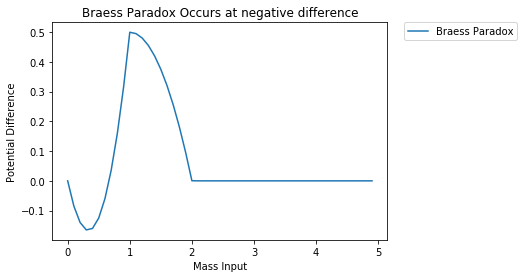

In [309]:
plt.figure()
plt.plot(socialFull[0,:],socialFull[1,:] - socialNoEdge[1,:],label=("Braess Paradox"));

plt.xlabel('Mass Input')
plt.ylabel('Potential Difference')
plt.title('Braess Paradox Occurs at negative difference')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [310]:
#--------------------------------------OLD CODE---------------------------------#   
# massIterations = 50;
# potComp = np.zeros([3,massIterations]);
# newQ = np.zeros([2,massIterations]);
# RouteMat = RouteGen(wheat,edges,sourceNode,sinkNode)
# for massInd in range(0,massIterations):
#     # Problem data.
#     # mass = i;
#     mass = 0.1*massInd;
#     potComp[0,massInd] = mass;
#     print("_________________MASS_________________")
#     print(" mass = "+str(mass))
#     # Construct the problem.
#     #----------------WARDROP EQUILIBRIUM--------------------
#     x = Variable(e); 
#     z = Variable(len(routes));
#     warPot =  b*x + quad_form(x,A)*0.5;
#     warObj = Minimize(warPot);
#     warConstraints = [0 <= z, 
#                       RouteMat*z == x,
#                       sum(z) == mass]
#     wardrop = Problem(warObj, warConstraints)
#     warRes = wardrop.solve(solver=CVXOPT)
# #     pOpt = x.value;
# #     z = sla.inv(RouteMat.T.dot(RouteMat)).dot(RouteMat.T).dot(xOpt)
#     print("------Wardrop--------")
#     print(z.value)
#     print(warPot.value)
#     potComp[1,massInd] = warPot.value;
#     newQ[0,massInd] = Q(x.value);
#     #----------------SOCIAL EQUILIBRIUM---------------------
#     y = Variable(e); 
#     z = Variable(len(routes));
#     socialPot = b*y + quad_form(y,A);
#     socailObj = Minimize(socialPot);
#     socialConstraints = [0 <= z, 
#                          RouteMat*z == y,
#                          sum(z) == mass]
#     social =Problem(socailObj, socialConstraints) 
#     socialRes = social.solve(solver=MOSEK)
#     print("------Social--------")
#     print(z.value)
#     potComp[2,massInd] = socialPot.value;
# #     print(result)
#     # The optimal value for x is stored in x.value.
# #     print x.value
#     # The optimal Lagrange multiplier for a constraint
#     # is stored in constraint.dual_value.
#     # print constraints[0].dual_value
# # Remove an edge and try again
# # Graph set up 
# edges = [(0,1),(0,2), (2,3), (1,3)] ;
# wheat = nx.DiGraph(edges);
# # Degree/Incidence matrix
# E = nx.incidence_matrix(wheat, oriented=True).toarray();
# # print(E)
# # Number of edges
# e = wheat.number_of_edges();
# # Number of nodes
# v = wheat.number_of_nodes();

# # Generate routes matrix
# routes =  list(nx.all_simple_paths(wheat, source=sourceNode, target=sinkNode));
# RouteMat = np.zeros((wheat.number_of_edges(), len(routes)));
# for route in range(0,len(routes)):
#     curRoute = routes[route];#Route is in nodes
#     #Look for the index of corresponding edge
#     for edge in range(0,len(curRoute)-1):
#         #Unpack edge
#         start= curRoute[edge]; end = curRoute[edge+1];
#         edgeInd = edges.index((start,end)); #find the edge index in list
#         RouteMat[edgeInd,route]= 1;
        
# A = np.diag([1., 0, 1, 0.])
# b = np.array([0., 1., 0, 1.])
# def latency(x): 
#     return A.dot(x) +b;
# def P(x): # Wardrop Potential
#     xTrans = x.T.dot(A)
#     return 0.5*x.T.dot(A).dot(x) + b.T.dot(x);
# def Q(x):  # Average Potential
#     return x.T.dot(A.dot(x)) + b.T.dot(x);



# for massInd in range(0,massIterations):
#     # Problem data.
#     # mass = i;
#     mass = 0.1*massInd;
#     potComp[0,massInd] = mass;
# #     print("_________________MASS_________________")
# #     print(" mass = "+str(mass))
#     # Construct the problem.
#     #----------------WARDROP EQUILIBRIUM--------------------
#     x = Variable(e); 
#     z = Variable(len(routes));
#     warPot =  b*x + quad_form(x,A)*0.5;#b.T.dot(x)
#     warObj = Minimize(warPot);
#     warConstraints = [0 <= z, 
#                       RouteMat*z == x,
#                       sum(z) == mass]
#     wardrop = Problem(warObj, warConstraints)
#     warRes = wardrop.solve(solver=MOSEK)
# #     pOpt = x.value;
# #     z = sla.inv(RouteMat.T.dot(RouteMat)).dot(RouteMat.T).dot(xOpt)
# #     print("------Wardrop--------")
# #     print(z.value)
# #     print(warPot.value)
#     newQ[1, massInd] = Q(x.value);
